# TER M1 IASD 2025

### Sonia KECHAOU
### Rim LEMRABOTT
### Fannie RUIZ

Deuxième Fine-tuning du TER : CamemBERT-NER

Voir section *4.3  Fine-tuning de CamemBERT-NER* du rapport.

In [2]:
import sys
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import transformers
from transformers import CamembertModel, CamembertTokenizerFast, CamembertForTokenClassification
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import Trainer, TrainingArguments, DataCollatorForTokenClassification

from torch.optim import AdamW
import torch.nn as nn
from torch.utils.data import DataLoader
import torch
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import Dataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report

import random
from collections import defaultdict

from tqdm import tqdm

In [2]:
# Chargement du modèle pré-entraîné sur la tâche NER
model_name = "Jean-Baptiste/camembert-ner"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tag2id = {
    'O': 0,
    'I-PER': 1,
    'I-ORG': 2,
    'I-LOC': 3,
    'I-MISC': 4,
    'I-DATE': 5,
    'I-FUM': 6
}
id2tag = {v: k for k, v in tag2id.items()}
num_labels = len(tag2id)


model = AutoModelForTokenClassification.from_pretrained(
    "Jean-Baptiste/camembert-ner",
    num_labels=len(tag2id),
    id2label=id2tag,
    label2id=tag2id,
    ignore_mismatched_sizes=True
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/269 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/892 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of CamembertForTokenClassification were not initialized from the model checkpoint at Jean-Baptiste/camembert-ner and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([5]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([5, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
print(model.classifier)

Linear(in_features=768, out_features=7, bias=True)


In [3]:
medical_full = [

    {"tokens": ["Je", "ne", "fume", "que", "une", "fois", "par", "jour", "."],
     "ner_tags": ["O", "O", "I-FUM", "O", "O", "O", "O", "O", "O"]},

    {"tokens": ["Est-ce", "que", "vous", "fumez", "?", "non", ".", "Vous", "vapotez", "?", "non", "plus", "."],
     "ner_tags": ["O", "O", "O", "I-FUM", "O", "I-FUM", "O", "O", "I-FUM", "O", "I-FUM", "O", "O"]},

    {"tokens": ["La", "vaporette", "est", "tout", "aussi", "mauvaise", "que", "la", "cigarette", "."],
     "ner_tags": ["O", "I-FUM", "O", "O", "O", "O", "O", "O", "I-FUM", "O"]},

    {"tokens": ["Aucune", "cigarette", "ou", "vaporette", "ne", "sera", "tolérée", "."],
     "ner_tags": ["O", "I-FUM", "O", "I-FUM", "O", "O", "O", "O"]},

    {"tokens": ["Je", "n'ai", "pas", "touché", "à", "une", "vapoteuse", "depuis", "des", "mois", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "O", "I-FUM", "O", "O", "O", "O"]},

    {"tokens": ["Fumer", "peut", "nuire", "à", "la", "santé", "."],
     "ner_tags": ["I-FUM", "O", "O", "O", "O", "O", "O"]},

    {"tokens": ["Il", "a", "commencé", "à", "fumer", "en", "cachette", "depuis", "le", "lycée", "."],
     "ner_tags": ["O", "O", "O", "O", "I-FUM", "O", "O", "O", "O", "O", "O"]},

    {"tokens": ["Elle", "a", "testé", "le", "vapoteur", "pendant", "un", "mois", "."],
     "ner_tags": ["O", "O", "O", "O", "I-FUM", "O", "O", "O", "O"]},

    {"tokens": ["Je", "me", "suis", "engagé", "à", "ne", "plus", "jamais", "fumer", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "O", "O", "O", "I-FUM", "O"]},

    {"tokens": ["Depuis", "qu'il", "a", "arrêté", "la", "clope", ",", "il", "se", "sent", "mieux", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "I-FUM", "O", "O", "O", "O", "O", "O"]},

    {'tokens': ['Je', 'fume', 'une', 'cigarette', 'par', 'jour', '.'],
     'ner_tags': ['O', 'I-FUM', 'O', 'I-FUM', 'O', 'O', 'O']},

    {'tokens': ['Il', 'vapote', 'après', 'chaque', 'repas', '.'],
     'ner_tags': ['O', 'I-FUM', 'O', 'O', 'O', 'O']},

    {'tokens': ['Elle', 'a', 'arrêté', 'le', 'tabac', 'depuis', 'deux', 'ans', '.'],
     'ner_tags': ['O', 'O', 'O', 'O', 'I-FUM', 'O', 'O', 'O', 'O']},

    {'tokens': ['Les', 'e-cigarettes', 'ne', 'sont', 'pas', 'meilleures', '.'],
     'ner_tags': ['O', 'I-FUM', 'O', 'O', 'O', 'O', 'O']},

    {'tokens': ['Je', 'vapote', 'moins', 'depuis', "l'année", 'dernière', '.'],
     'ner_tags': ['O', 'I-FUM', 'O', 'O', 'O', 'O', 'O']},

    {'tokens': ['La', 'vaporette', 'est', 'interdite', 'ici', '.'],
     'ner_tags': ['O', 'I-FUM', 'O', 'O', 'O', 'O']},

    {'tokens': ['Il', 'ne', 'fume', 'plus', 'du', 'tout', '.'],
     'ner_tags': ['O', 'O', 'I-FUM', 'O', 'O', 'O', 'O']},

    {'tokens': ['Je', 'préfère', 'la', 'clope', 'à', 'la', 'vaporette', '.'],
     'ner_tags': ['O', 'O', 'O', 'I-FUM', 'O', 'O', 'I-FUM', 'O']},

    {'tokens': ['La', 'cigarette', 'électronique', 'est', 'dangereuse', '.'],
     'ner_tags': ['O', 'I-FUM', 'I-FUM', 'O', 'O', 'O']},

    {'tokens': ['Il', 'vapote', 'depuis', 'quatre', 'ans', '.'],
     'ner_tags': ['O', 'I-FUM', 'O', 'O', 'O', 'O']},

    {'tokens': ['Les', 'adolescents', 'utilisent', 'de', 'plus', 'en', 'plus', 'la', 'vape', '.'],
     'ner_tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-FUM', 'O']},

    {'tokens': ['Je', 'fume', 'depuis', 'le', 'lycée', '.'],
     'ner_tags': ['O', 'I-FUM', 'O', 'O', 'O', 'O']},

    {'tokens': ['La', 'clope', 'électronique', 'est', 'populaire', 'chez', 'les', 'jeunes', '.'],
     'ner_tags': ['O', 'I-FUM', 'I-FUM', 'O', 'O', 'O', 'O', 'O', 'O']},

    {'tokens': ['Elle', 'a', 'acheté', 'une', 'vaporette', 'hier', '.'],
     'ner_tags': ['O', 'O', 'O', 'O', 'I-FUM', 'O', 'O']},

    {'tokens': ['Il', 'fume', 'des', 'cigarettes', 'light', '.'],
     'ner_tags': ['O', 'I-FUM', 'O', 'I-FUM', 'O', 'O']},

    {'tokens': ['Je', 'déteste', 'l', "'", 'odeur', 'du', 'tabac', '.'],
     'ner_tags': ['O', 'O', 'O', 'O', 'O', 'O', 'I-FUM', 'O']},

    {'tokens': ['Elle', 'aime', 'la', 'sensation', 'de', 'vapoter', '.'],
     'ner_tags': ['O', 'O', 'O', 'O', 'O', 'I-FUM', 'O']},

    {"tokens": ["Vous", "fumez", "encore", "?", "oui", "."],
     "ner_tags": ["O", "I-FUM", "O", "O", "I-FUM", "O"]},

    {"tokens": ["Est-ce", "que", "vous", "vapotez", "?", "non", "."],
     "ner_tags": ["O", "O", "O", "I-FUM", "O", "I-FUM", "O"]},

    {"tokens": ["Tu", "utilises", "une", "vaporette", "?", "oui", "."],
     "ner_tags": ["O", "O", "O", "I-FUM", "O", "I-FUM", "O"]},

    {"tokens": ["Fumez-vous", "?", "non", "."],
     "ner_tags": ["I-FUM", "O", "I-FUM", "O"]},

    {"tokens": ["Est-ce", "que", "tu", "fumes", "?", "non", "."],
     "ner_tags": ["O", "O", "O", "I-FUM", "O", "I-FUM", "O"]},

    {"tokens": ["Vous", "avez", "déjà", "fumé", "?", "oui", "."],
     "ner_tags": ["O", "O", "O", "I-FUM", "O", "I-FUM", "O"]},

    {"tokens": ["Elle", "vapote", "toujours", "?", "non", "."],
     "ner_tags": ["O", "I-FUM", "O", "O", "I-FUM", "O"]},

    {"tokens": ["Tu", "fumes", "la", "cigarette", "?", "oui", "."],
     "ner_tags": ["O", "I-FUM", "O", "I-FUM", "O", "I-FUM", "O"]},

    {"tokens": ["Est-ce", "que", "vous", "utilisez", "une", "e-cigarette", "?", "non", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "I-FUM", "O", "I-FUM", "O"]},

    {"tokens": ["Vous", "avez", "déjà", "essayé", "de", "vapoter", "?", "oui", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "I-FUM", "O", "I-FUM", "O"]},

    {"tokens": ["Il", "fume", "encore", "?", "non", "."],
     "ner_tags": ["O", "I-FUM", "O", "O", "I-FUM", "O"]},

    {"tokens": ["Tu", "vapotes", "?", "oui", "."],
     "ner_tags": ["O", "I-FUM", "O", "I-FUM", "O"]},

    {"tokens": ["Vous", "fumez", "?", "non", "."],
     "ner_tags": ["O", "I-FUM", "O", "I-FUM", "O"]},

    {"tokens": ["Elle", "a", "arrêté", "la", "clope", "?", "oui", "."],
     "ner_tags": ["O", "O", "O", "O", "I-FUM", "O", "I-FUM", "O"]},

    {"tokens": ["Vous", "avez", "déjà", "fumé", "une", "vaporette", "?", "non", "."],
     "ner_tags": ["O", "O", "O", "I-FUM", "O", "I-FUM", "O", "I-FUM", "O"]},

    {"tokens": ["Tu", "utilises", "la", "clope", "électronique", "?", "non", "."],
     "ner_tags": ["O", "O", "O", "I-FUM", "I-FUM", "O", "I-FUM", "O"]},

    {"tokens": ["Tu", "as", "déjà", "fumé", "?", "oui", "."],
     "ner_tags": ["O", "O", "O", "I-FUM", "O", "I-FUM", "O"]},

    {"tokens": ["Fumes-tu", "?", "non", "."],
     "ner_tags": ["I-FUM", "O", "I-FUM", "O"]},

    {"tokens": ["Elle", "utilise", "une", "vapoteuse", "?", "non", "."],
     "ner_tags": ["O", "O", "O", "I-FUM", "O", "I-FUM", "O"]},

    {"tokens": ["Vous", "utilisez", "encore", "la", "vaporette", "?", "oui", "."],
     "ner_tags": ["O", "O", "O", "O", "I-FUM", "O", "I-FUM", "O"]},

    {'tokens': ['Le', '13', 'mars', '1965', 'je', 'suis', 'parti', 'en', 'voyage', '.'],
     'ner_tags': ['O', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O']},

    {'tokens': ['Le', '12', 'juillet', '1987', 'ils', 'ont', 'signé', 'le', 'contrat', '.'],
     'ner_tags': ['O', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O']},

    {'tokens': ['Un', 'mariage', 'a', 'été', 'célébré', 'le', '14', 'décembre', '2018', '.'],
     'ner_tags': ['O', 'O', 'O', 'O', 'O', 'O', 'I-DATE', 'I-DATE', 'I-DATE', 'O']},

    {'tokens': ['Le', '11', 'octobre', '2003', 'était', 'un', 'jour', 'très', 'important', '.'],
     'ner_tags': ['O', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O']},

    {'tokens': ['Nous', 'avons', 'eu', 'notre', 'premier', 'enfant', 'le', '13', 'août', '1996', '.'],
     'ner_tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-DATE', 'I-DATE', 'I-DATE', 'O']},

    {'tokens': ['Le', '7', 'mars', '1977', 'j’ai', 'déménagé', 'à', 'Paris', '.'],
     'ner_tags': ['O', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O']},

    {'tokens': ['Un', 'événement', 'historique', 'a', 'eu', 'lieu', 'le', '24', 'janvier', '2000', '.'],
     'ner_tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-DATE', 'I-DATE', 'I-DATE', 'O']},

    {'tokens': ['Le', '1', 'mai', '1952', 'a', 'été', 'déclaré', 'jour', 'férié', '.'],
     'ner_tags': ['O', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O', 'O', 'O']},

    {'tokens': ['Le', '9', 'février', '2022', 'j’étais', 'en', 'congé', '.'],
     'ner_tags': ['O', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O']},

    {'tokens': ['Un', 'concert', 'a', 'eu', 'lieu', 'le', '18', 'novembre', '1982', '.'],
     'ner_tags': ['O', 'O', 'O', 'O', 'O', 'O', 'I-DATE', 'I-DATE', 'I-DATE', 'O']},

    {'tokens': ['Mon', 'rendez-vous', 'chez', 'le', 'médecin', 'était', 'le', '15', 'juin', '2010', '.'],
     'ner_tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-DATE', 'I-DATE', 'I-DATE', 'O']},

    {'tokens': ['Le', '6', 'septembre', '1999', 'j’ai', 'commencé', 'l’université', '.'],
     'ner_tags': ['O', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O']},

    {'tokens': ['Mon', 'permis', 'de', 'conduire', 'a', 'été', 'délivré', 'le', '20', 'juin', '1975', '.'],
     'ner_tags': ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'I-DATE', 'I-DATE', 'I-DATE', 'O']},

    {'tokens': ['Le', '4', 'avril', '1995', 'j’étais', 'en', 'vacances', '.'],
     'ner_tags': ['O', 'I-DATE', 'I-DATE', 'I-DATE', 'O', 'O', 'O', 'O']},

    {'tokens': ['Un', 'accident', 'a', 'eu', 'lieu', 'le', '30', 'août', '2001', '.'],
     'ner_tags': ['O', 'O', 'O', 'O', 'O', 'O', 'I-DATE', 'I-DATE', 'I-DATE', 'O']},

    {"tokens": ["Le", "dernier", "paquet", "a", "été", "acheté", "le", "28", "février", "2024", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "O", "O", "I-DATE", "I-DATE", "I-DATE", "O"]},

     {"tokens": ["Je", "dois", "revenir", "le", "7", "septembre", "prochain", "pour", "le", "suivi", "."],
     "ner_tags": ["O", "O", "O", "O", "I-DATE", "I-DATE", "I-DATE", "O", "O", "O", "O"]},

    {"tokens": ["Rendez-vous", "pris", "pour", "le", "12", "juin", "à", "10h", "."],
     "ner_tags": ["O", "O", "O", "O", "I-DATE", "I-DATE", "O", "O", "O"]},

    {"tokens": ["Elle", "a", "été", "hospitalisée", "en", "décembre", "dernier", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["C’était", "le", "jour", "de", "Noël", "qu’on", "l’a", "opéré", "."],
     "ner_tags": ["O", "O", "O", "O", "I-DATE", "O", "O", "O", "O"]},

    {"tokens": ["La", "consultation", "est", "prévue", "mi-mars", "."],
     "ner_tags": ["O", "O", "O", "O", "I-DATE", "O"]},

    {"tokens": ["Il", "est", "né", "un", "certain", "4", "juillet", "1972", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "I-DATE", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["Les", "symptômes", "ont", "commencé", "autour", "du", "15", "janvier", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "O", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["Il", "a", "été", "vacciné", "en", "février", "2021", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["Le", "traitement", "s'est", "terminé", "vers", "mars", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "I-DATE", "O"]},

    {"tokens": ["Le", "rapport", "date", "du", "03", "/", "08", "/", "2023", "."],
     "ner_tags": ["O", "O", "O", "O", "I-DATE", "I-DATE", "I-DATE", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["Je", "l’ai", "vu", "avant-hier", "."],
     "ner_tags": ["O", "O", "O", "I-DATE", "O"]},

    {"tokens": ["On", "part", "en", "vacances", "fin", "août", "."],
     "ner_tags": ["O", "O", "O", "O", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["La", "prochaine", "consultation", "est", "prévue", "dans", "deux", "semaines", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "O", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["Le", "premier", "cas", "a", "été", "signalé", "en", "mars", "2020", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "O", "O", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["L'étude", "a", "commencé", "au", "printemps", "2019", "."],
     "ner_tags": ["O", "O", "O", "O", "I-DATE", "I-DATE", "O"]},

    {'tokens': ['Elle', 'a', 'commencé', 'à', 'vapoter', 'en', '2020', '.'],
     'ner_tags': ['O', 'O', 'O', 'O', 'I-FUM', 'O', 'I-DATE', 'O']},

    {"tokens": ["Il", "a", "commencé", "à", "vapoter", "le", "5", "mai", "2019", "."],
     "ner_tags": ["O", "O", "O", "O", "I-FUM", "O", "I-DATE", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["Elle", "a", "arrêté", "de", "fumer", "depuis", "janvier", "2020", "."],
     "ner_tags": ["O", "O", "O", "O", "I-FUM", "O", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["La", "cigarette", "électronique", "est", "interdite", "depuis", "le", "15", "août", "2021", "."],
     "ner_tags": ["O", "I-FUM", "I-FUM", "O", "O", "O", "O", "I-DATE", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["Il", "a", "repris", "la", "cigarette", "en", "mars", "."],
     "ner_tags": ["O", "O", "O", "O", "I-FUM", "O", "I-DATE", "O"]},

    {"tokens": ["Depuis", "le", "1er", "janvier", "2023", ",", "elle", "ne", "fume", "plus", "."],
     "ner_tags": ["O", "O", "I-DATE", "I-DATE", "I-DATE", "O", "O", "O", "I-FUM", "O", "O"]},

    {"tokens": ["Le", "tabac", "sera", "banni", "dès", "février", "2027", "."],
     "ner_tags": ["O", "I-FUM", "O", "O", "O", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["Elle", "ne", "vapote", "plus", "depuis", "le", "10", "décembre", "2022", "."],
     "ner_tags": ["O", "O", "I-FUM", "O", "O", "O", "I-DATE", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["Je", "ne", "touche", "plus", "à", "la", "cigarette", "depuis", "le", "31", "décembre", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "O", "I-FUM", "O", "O", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["On", "a", "détecté", "la", "consommation", "de", "tabac", "en", "septembre", "2020", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "O", "I-FUM", "O", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["Ils", "ont", "interdit", "la", "cigarette", "au", "travail", "depuis", "2018", "."],
     "ner_tags": ["O", "O", "O", "O", "I-FUM", "O", "O", "O", "I-DATE", "O"]},

    {"tokens": ["L'arrêt", "du", "tabac", "a", "été", "fixé", "au", "3", "février", "."],
     "ner_tags": ["O", "O", "I-FUM", "O", "O", "O", "O", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["Le", "tabac", "n'est", "plus", "vendu", "dans", "cet", "établissement", "depuis", "le", "1er", "mars", "2022", "."],
     "ner_tags": ["O", "I-FUM", "O", "O", "O", "O", "O", "O", "O", "O", "I-DATE", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["On", "lui", "a", "prescrit", "des", "patchs", "nicotiniques", "depuis", "le", "mois", "d'", "avril", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "I-FUM", "I-FUM", "O", "O", "O", "O", "I-DATE", "O"]},

    {"tokens": ["La", "décision", "d'arrêter", "de", "vapoter", "a", "été", "prise", "le", "12", "janvier", "2025", "."],
     "ner_tags": ["O", "O", "O", "O", "I-FUM", "O", "O", "O", "O", "I-DATE", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["Je", "n'ai", "pas", "fumé", "depuis", "le", "Réveillon", "."],
     "ner_tags": ["O", "O", "O", "I-FUM", "O", "O", "I-DATE", "O"]},

    {"tokens": ["Le", "gouvernement", "a", "annoncé", "une", "interdiction", "des", "vaporettes", "à", "partir", "de", "juillet", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "O", "O", "I-FUM", "O", "O", "O", "I-DATE", "O"]},

    {"tokens": ["Fumer", "à", "l'intérieur", "est", "strictement", "prohibé", "depuis", "2007", "."],
     "ner_tags": ["I-FUM", "O", "O", "O", "O", "O", "O", "I-DATE", "O"]},

    {"tokens": ["Il", "a", "été", "condamné", "pour", "vente", "de", "tabac", "illégale", "en", "2022", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "O", "O", "I-FUM", "O", "O", "I-DATE", "O"]},

    {"tokens": ["On", "devrait", "arrêter", "le", "tabac", "au", "moins", "avant", "septembre", "."],
     "ner_tags": ["O", "O", "O", "O", "I-FUM", "O", "O", "O", "I-DATE", "O"]},

    {"tokens": ["J’ai", "recommencé", "la", "clope", "quand", "j’ai", "perdu", "mon", "emploi", "en", "mars", "."],
     "ner_tags": ["O", "O", "O", "I-FUM", "O", "O", "O", "O", "O", "O", "I-DATE", "O"]},

    {"tokens": ["Mon", "dernier", "cigare", "remonte", "à", "novembre", "dernier", "."],
     "ner_tags": ["O", "O", "I-FUM", "O", "O", "I-DATE", "O", "O"]},

    {"tokens": ["Plus", "aucune", "vapoteuse", "n’est", "autorisée", "dans", "ce", "bâtiment", "depuis", "le", "15", "mars", "."],
     "ner_tags": ["O", "O", "I-FUM", "O", "O", "O", "O", "O", "O", "O", "I-DATE", "I-DATE", "O"]},

    {"tokens": ["Tu", "as", "encore", "craqué", "pour", "la", "clope", "?", "C'était", "le", "1er", "janvier", "non", "?" ],
     "ner_tags": ["O", "O", "O", "O", "O", "O", "I-FUM", "O", "O", "O", "I-DATE", "I-DATE", "O", "O"]},

    {"tokens": ["Emmanuel", "Macron", "a", "rencontré", "Justin", "Trudeau", "à", "Paris", "."],
     "ner_tags": ["I-PER", "I-PER", "O", "O", "I-PER", "I-PER", "O", "I-LOC", "O"]},

    {"tokens": ["Google", "France", "a", "ouvert", "un", "nouveau", "bureau", "à", "Lyon", "."],
     "ner_tags": ["I-ORG", "I-ORG", "O", "O", "O", "O", "O", "O", "I-LOC", "O"]},

    {"tokens": ["Le", "Tour", "de", "France", "commencera", "en", "juillet", "."],
     "ner_tags": ["O", "I-MISC", "I-MISC", "I-MISC", "O", "O", "O", "O"]},

    {"tokens": ["Marie", "Curie", "était", "une", "scientifique", "polonaise", "."],
     "ner_tags": ["I-PER", "I-PER", "O", "O", "O", "I-MISC", "O"]},

    {"tokens": ["Le", "Président", "s'est", "rendu", "à", "Bruxelles", "pour", "le", "sommet", "européen", "."],
     "ner_tags": ["O", "O", "O", "O", "O", "I-LOC", "O", "O", "O", "I-MISC", "O"]},

    {"tokens": ["Léa", "Seydoux", "a", "joué", "dans", "un", "film", "de", "James", "Bond", "."],
     "ner_tags": ["I-PER", "I-PER", "O", "O", "O", "O", "O", "O", "I-MISC", "I-MISC", "O"]},

    {"tokens": ["Le", "Louvre", "est", "l'un", "des", "musées", "les", "plus", "visités", "du", "monde", "."],
     "ner_tags": ["I-LOC", "I-LOC", "O", "O", "O", "O", "O", "O", "O", "O", "O", "O"]},

    {"tokens": ["Airbus", "et", "Boeing", "sont", "des", "concurrents", "historiques", "."],
     "ner_tags": ["I-ORG", "O", "I-ORG", "O", "O", "O", "O", "O"]},

    {"tokens": ["Le", "festival", "de", "Cannes", "accueille", "des", "stars", "du", "monde", "entier", "."],
     "ner_tags": ["O", "I-MISC", "I-MISC", "I-MISC", "O", "O", "O", "O", "O", "O", "O"]},

    {"tokens": ["Jean", "Dujardin", "a", "remporté", "un", "Oscar", "en", "2012", "."],
     "ner_tags": ["I-PER", "I-PER", "O", "O", "O", "I-MISC", "O", "O", "O"]},

    {"tokens": ["L'ONU", "a", "tenu", "une", "conférence", "à", "Genève", "."],
     "ner_tags": ["I-ORG", "O", "O", "O", "O", "O", "I-LOC", "O"]},

    {"tokens": ["France", "Télévisions", "diffuse", "les", "Jeux", "Olympiques", "."],
     "ner_tags": ["I-ORG", "I-ORG", "O", "O", "I-MISC", "I-MISC", "O"]},

    {"tokens": ["Napoléon", "Bonaparte", "est", "né", "en", "Corse", "."],
     "ner_tags": ["I-PER", "I-PER", "O", "O", "O", "I-LOC", "O"]},

    {"tokens": ["Facebook", "a", "changé", "son", "nom", "en", "Meta", "Platforms", "."],
     "ner_tags": ["I-ORG", "O", "O", "O", "O", "O", "I-ORG", "I-ORG", "O"]},

    {"tokens": ["Le", "Mont", "Blanc", "est", "le", "plus", "haut", "sommet", "d'Europe", "."],
     "ner_tags": ["I-LOC", "I-LOC", "I-LOC", "O", "O", "O", "O", "O", "I-LOC", "O"]},

    {"tokens": ["Angela", "Merkel", "a", "saluté", "Joe", "Biden", "à", "Berlin", "."],
    "ner_tags": ["I-PER", "I-PER", "O", "O", "I-PER", "I-PER", "O", "I-LOC", "O"]},

	{"tokens": ["Microsoft", "Europe", "a", "annoncé", "un", "nouveau", "centre", "à", "Marseille", "."],
	"ner_tags": ["I-ORG", "I-ORG", "O", "O", "O", "O", "O", "O", "I-LOC", "O"]},

	{"tokens": ["La", "Coupe", "du", "Monde", "débute", "en", "novembre", "."],
	"ner_tags": ["O", "I-MISC", "I-MISC", "I-MISC", "O", "O", "I-DATE", "O"]},

	{"tokens": ["Isaac", "Newton", "était", "un", "physicien", "anglais", "."],
	"ner_tags": ["I-PER", "I-PER", "O", "O", "O", "I-MISC", "O"]},

	{"tokens": ["Le", "Premier", "ministre", "s'est", "rendu", "à", "Madrid", "pour", "le", "congrès", "international", "."],
	"ner_tags": ["I-PER", "I-PER", "I-PER", "O", "O", "O", "I-LOC", "O", "O", "O", "I-MISC", "O"]},

	{"tokens": ["Vincent", "Cassel", "a", "joué", "dans", "un", "film", "de", "Batman", "Begins", "."],
	"ner_tags": ["I-PER", "I-PER", "O", "O", "O", "O", "O", "O", "I-MISC", "I-MISC", "O"]},

	{"tokens": ["Le", "Musée", "d'Orsay", "est", "situé", "au", "cœur", "de", "Paris", "."],
	"ner_tags": ["I-LOC", "I-LOC", "I-LOC", "O", "O", "O", "O", "O", "I-LOC", "O"]},

	{"tokens": ["Peugeot", "et", "Renault", "sont", "des", "rivaux", "historiques", "."],
	"ner_tags": ["I-ORG", "O", "I-ORG", "O", "O", "O", "O", "O"]},

	{"tokens": ["Le", "carnaval", "de", "Rio", "attire", "des", "touristes", "du", "monde", "entier", "."],
	"ner_tags": ["O", "I-MISC", "I-MISC", "I-MISC", "O", "O", "O", "O", "O", "O", "O"]},

	{"tokens": ["Omar", "Sy", "a", "remporté", "un", "César", "en", "2011", "."],
	"ner_tags": ["I-PER", "I-PER", "O", "O", "O", "I-MISC", "O", "I-DATE", "O"]},

	{"tokens": ["L'UNESCO", "a", "organisé", "une", "réunion", "à", "Nairobi", "."],
	"ner_tags": ["I-ORG", "O", "O", "O", "O", "O", "I-LOC", "O"]},

	{"tokens": ["France", "Inter", "diffuse", "les", "Championnats", "Européens", "."],
	"ner_tags": ["I-ORG", "I-ORG", "O", "O", "I-MISC", "I-MISC", "O"]},

	{"tokens": ["Victor", "Hugo", "est", "enterré", "à", "Paris", "."],
	"ner_tags": ["I-PER", "I-PER", "O", "O", "O", "I-LOC", "O"]},

	{"tokens": ["Twitter", "a", "été", "renommé", "en", "X", "Corp", "."],
	"ner_tags": ["I-ORG", "O", "O", "O", "O", "I-ORG", "I-ORG", "O"]},

	{"tokens": ["Le", "Pic", "du", "Midi", "est", "un", "sommet", "célèbre", "des", "Pyrénées", "."],
	"ner_tags": ["I-LOC", "I-LOC", "I-LOC", "I-LOC", "O", "O", "O", "O", "O", "I-LOC", "O"]},

	{"tokens": ["Elon", "Musk", "a", "visité", "la", "Tesla", "Gigafactory", "à", "Berlin", "."],
	"ner_tags": ["I-PER", "I-PER", "O", "O", "O", "I-ORG", "I-ORG", "O", "I-LOC", "O"]},

	{"tokens": ["La", "Compagnie", "des", "Indes", "orientales", "a", "été", "fondée", "au", "XVIIe", "siècle", "."],
	"ner_tags": ["I-ORG", "I-ORG", "I-ORG", "I-ORG", "I-ORG", "O", "O", "O", "O", "O", "O", "O"]},

	{"tokens": ["Albert", "Einstein", "a", "passé", "du", "temps", "à", "Princeton", "."],
	"ner_tags": ["I-PER", "I-PER", "O", "O", "O", "O", "O", "I-LOC", "O"]},

	{"tokens": ["Le", "festival", "de", "Venise", "récompense", "les", "films", "d’auteur", "."],
	"ner_tags": ["O", "I-MISC", "I-MISC", "I-MISC", "O", "O", "O", "O", "O"]},

	{"tokens": ["Le", "CERN", "a", "annoncé", "une", "découverte", "majeure", "en", "physique", "."],
	"ner_tags": ["I-ORG", "I-ORG", "O", "O", "O", "O", "O", "O", "I-MISC", "O"]},

	{"tokens": ["Mahatma", "Gandhi", "est", "une", "figure", "emblématique", "de", "l’Inde", "."],
	"ner_tags": ["I-PER", "I-PER", "O", "O", "O", "O", "O", "I-LOC", "O"]},

	{"tokens": ["L'Académie", "française", "a", "reçu", "de", "nouvelles", "candidatures", "."],
	"ner_tags": ["I-ORG", "I-ORG", "O", "O", "O", "O", "O", "O"]},

	{"tokens": ["La", "NASA", "enverra", "une", "mission", "sur", "Mars", "en", "2026", "."],
	"ner_tags": ["I-ORG", "I-ORG", "O", "O", "O", "O", "I-LOC", "O", "O", "I-DATE"]},

	{"tokens": ["Le", "prix", "Nobel", "de", "littérature", "a", "été", "attribué", "à", "un", "auteur", "japonais", "."],
	 "ner_tags": ["O", "O", "I-MISC", "I-MISC", "I-MISC", "O", "O", "O", "O", "O", "O", "I-MISC", "O"]},

	{"tokens": ["Simone", "Veil", "repose", "au", "Panthéon", "à", "Paris", "."],
	"ner_tags": ["I-PER", "I-PER", "O", "O", "I-LOC", "O", "I-LOC", "O"]},

	{"tokens": ["Barack", "Obama", "a", "donné", "une", "conférence", "à", "Tokyo", "."],
	"ner_tags": ["I-PER", "I-PER", "O", "O", "O", "O", "O", "I-LOC", "O"]},

	{"tokens": ["Amazon", "Web", "Services", "est", "leader", "du", "cloud", "."],
	"ner_tags": ["I-ORG", "I-ORG", "I-ORG", "O", "O", "O", "O", "O"]},

	{"tokens": ["Le", "Prix", "Goncourt", "a", "été", "décerné", "à", "un", "écrivain", "congolais", "."],
	"ner_tags": ["O", "I-MISC", "I-MISC", "O", "O", "O", "O", "O", "O", "O", "O"]},

	{"tokens": ["Stephen", "Hawking", "a", "étudié", "à", "Cambridge", "."],
	"ner_tags": ["I-PER", "I-PER", "O", "O", "O", "I-LOC", "O"]},

	{"tokens": ["Le", "FBI", "a", "ouvert", "une", "enquête", "sur", "des", "cyberattaques", "."],
	"ner_tags": ["I-ORG", "I-ORG", "O", "O", "O", "O", "O", "O", "O", "O"]},

	{"tokens": ["La", "Seconde", "Guerre", "mondiale", "a", "eu", "un", "impact", "mondial", "."],
	"ner_tags": ["I-MISC", "I-MISC", "I-MISC", "I-MISC", "O", "O", "O", "O", "O", "O"]},

	{"tokens": ["Cristiano", "Ronaldo", "joue", "en", "Arabie", "Saoudite", "."],
	"ner_tags": ["I-PER", "I-PER", "O", "O", "I-LOC", "I-LOC", "O"]},

	{"tokens": ["L'université", "d'Oxford", "est", "parmi", "les", "meilleures", "du", "monde", "."],
	"ner_tags": ["I-ORG", "I-ORG", "O", "O", "O", "O", "O", "O", "O"]},

	{"tokens": ["Le", "Dalai", "Lama", "a", "visité", "l'Inde", "en", "mars", "."],
	"ner_tags": ["I-PER", "I-PER", "I-PER", "O", "O", "I-LOC", "O", "I-DATE", "O"]},

	{"tokens": ["Spotify", "et", "Deezer", "se", "disputent", "le", "marché", "du", "streaming", "."],
	"ner_tags": ["I-ORG", "O", "I-ORG", "O", "O", "O", "O", "O", "O", "O"]},

	{"tokens": ["Serena", "Williams", "a", "annoncé", "sa", "retraite", "du", "tennis", "."],
	"ner_tags": ["I-PER", "I-PER", "O", "O", "O", "O", "O", "I-MISC", "O"]},

	{"tokens": ["Le", "Vatican", "est", "le", "plus", "petit", "État", "du", "monde", "."],
	 "ner_tags": ["I-LOC", "I-LOC", "O", "O", "O", "O", "O", "O", "O", "O"]},

	{"tokens": ["Tesla", "a", "dévoilé", "un", "nouveau", "modèle", "électrique", "."],
	"ner_tags": ["I-ORG", "O", "O", "O", "O", "O", "O", "O"]},

	{"tokens": ["Le", "Marathon", "de", "New", "York", "attire", "des", "milliers", "de", "coureurs", "."],
	"ner_tags": ["O", "I-MISC", "I-MISC", "I-LOC", "I-LOC", "O", "O", "O", "O", "O", "O"]},

	{"tokens": ["Albert", "Einstein", "a", "reçu", "le", "prix", "Nobel", "de", "physique", "."],
	"ner_tags": ["I-PER", "I-PER", "O", "O", "O", "O", "I-MISC", "O", "O", "O"]},

	{"tokens": ["TikTok", "est", "interdit", "dans", "certains", "pays", "comme", "l'Inde", "."],
	 "ner_tags": ["I-ORG", "O", "O", "O", "O", "O", "O", "I-LOC", "O"]},

	{"tokens": ["La", "NASA", "prépare", "une", "nouvelle", "mission", "vers", "Mars", "."],
	"ner_tags": ["O", "I-ORG", "O", "O", "O", "O", "O", "I-LOC", "O"]},

	{"tokens": ["Coco", "Chanel", "a", "révolutionné", "la", "mode", "féminine", "."],
	"ner_tags": ["I-PER", "I-PER", "O", "O", "O", "O", "O", "O"]},

	{"tokens": ["L'Allemagne", "et", "la", "France", "ont", "signé", "un", "nouvel", "accord", "."],
	"ner_tags": ["I-LOC", "O", "O", "I-LOC", "O", "O", "O", "O", "O", "O"]},

	{"tokens": ["Le", "Comic", "Con", "de", "San", "Diego", "accueille", "des", "fans", "du", "monde", "."],
	"ner_tags": ["O", "I-MISC", "I-MISC", "O", "I-LOC", "I-LOC", "O", "O", "O", "O", "O", "O"]}
]

In [4]:
df = pd.DataFrame(medical_full)
display(df.head())
print(df.describe())

,tokens,ner_tags
0,"[Je, ne, fume, que, une, fois, par, jour, .]","[O, O, I-FUM, O, O, O, O, O, O]"
1,"[Est-ce, que, vous, fumez, ?, non, ., Vous, va...","[O, O, O, I-FUM, O, I-FUM, O, O, I-FUM, O, I-F..."
2,"[La, vaporette, est, tout, aussi, mauvaise, qu...","[O, I-FUM, O, O, O, O, O, O, I-FUM, O]"
3,"[Aucune, cigarette, ou, vaporette, ne, sera, t...","[O, I-FUM, O, I-FUM, O, O, O, O]"
4,"[Je, n'ai, pas, touché, à, une, vapoteuse, dep...","[O, O, O, O, O, O, I-FUM, O, O, O, O]"


                                              tokens  \
count                                            162   
unique                                           162   
top     [Je, ne, fume, que, une, fois, par, jour, .]   
freq                                               1   

                             ner_tags  
count                             162  
unique                            117  
top     [O, O, O, I-FUM, O, I-FUM, O]  
freq                                6  


In [25]:
dfCopy=df

df_exploded = dfCopy.explode('ner_tags')
tags_occurrences = df_exploded['ner_tags'].value_counts().to_dict()

display(tags_occurrences)

{'O': 1036,
 'I-DATE': 126,
 'I-FUM': 106,
 'I-PER': 50,
 'I-LOC': 46,
 'I-MISC': 46,
 'I-ORG': 45}

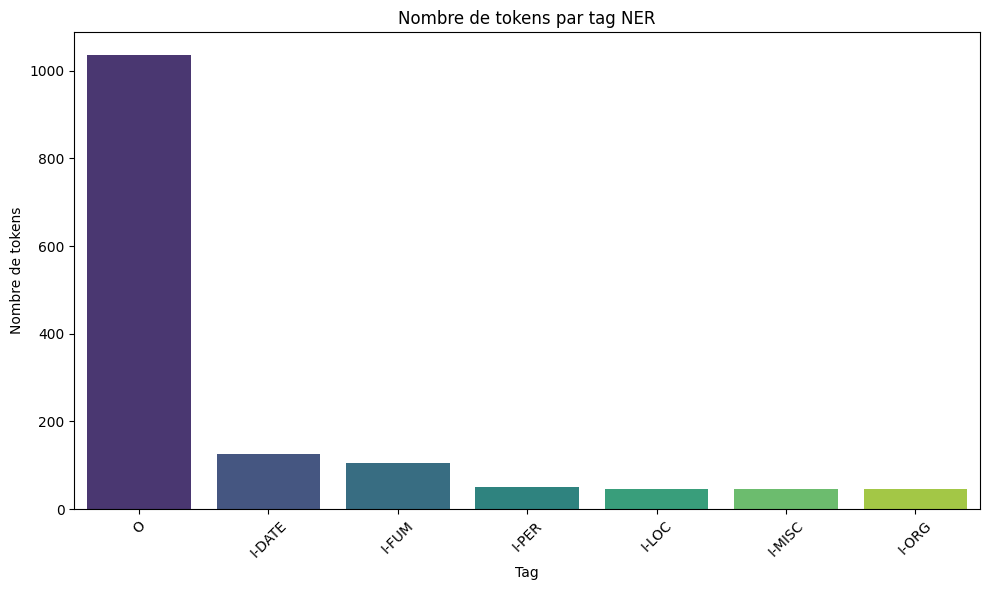

In [26]:
df_tags = pd.DataFrame(list(tags_occurrences.items()), columns=["Tag", "Count"])

df_tags = df_tags.sort_values("Count", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_tags, x="Tag", y="Count", palette="viridis")

plt.title("Nombre de tokens par tag NER")
plt.ylabel("Nombre de tokens")
plt.xlabel("Tag")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [30]:
def tokenize_and_align_labels(sentence):
    encoding = tokenizer(sentence["tokens"], is_split_into_words=True, return_offsets_mapping=True, truncation=True, padding='max_length', max_length=20)
    word_ids = encoding.word_ids()
    labels = [tag2id[tag] for tag in sentence["ner_tags"]]
    aligned = []
    prev_word = None
    for word_id in word_ids:
        if word_id is None:
            aligned.append(-100)
        elif word_id != prev_word:
            aligned.append(labels[word_id])
        else:
            aligned.append(-100)
        prev_word = word_id
    encoding["labels"] = aligned
    encoding.pop("offset_mapping", None)

    return encoding

tokenized_train_list = [tokenize_and_align_labels(e) for e in train_list]
tokenized_test_list = [tokenize_and_align_labels(e) for e in test_list]


print(tokenized_test_list[:3])

[{'input_ids': [5, 869, 771, 198, 4506, 1731, 49, 12, 41, 13101, 29, 44, 2143, 176, 16, 338, 697, 21, 9, 6], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 0, 0, 6, -100, -100, 0, -100, -100, 0, 0, 0, 0, 0, 0, 5, 5, 0, -100, -100]}, {'input_ids': [5, 100, 21225, 28, 12643, 37, 209, 21, 9, 6, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [-100, 0, 6, 0, 6, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]}, {'input_ids': [5, 100, 49, 11, 73, 34, 6584, 15, 28, 198, 4506, 1731, 176, 20, 250, 21, 9, 6, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], 'labels': [-100, 0, 0, -100, -100, 0, 0, 0, 0, 6, -100, -100, 0, 0, 0, 0, -100, -100, -100, -100]}]


In [31]:
label_list = list(tag2id.keys())

def compute_metrics(p):

    preds = np.argmax(p.predictions, axis=2)
    true_labels = []
    true_preds = []

    for pred_seq, label_seq in zip(preds, p.label_ids):
        for pred, label in zip(pred_seq, label_seq):
            if label != -100:
                true_labels.append(label_list[label])
                true_preds.append(label_list[pred])

    report = classification_report(true_labels, true_preds, labels=label_list, digits=4, output_dict=True)

    metrics = {}
    for label in label_list:
        metrics[f"f1_{label}"] = report[label]["f1-score"]
        metrics[f"precision_{label}"] = report[label]["precision"]
        metrics[f"recall_{label}"] = report[label]["recall"]
        metrics[f"support_{label}"] = report[label]["support"]

    metrics["f1_macro"] = report["macro avg"]["f1-score"]
    metrics["f1_weighted"] = report["weighted avg"]["f1-score"]
    metrics["accuracy"] = report["accuracy"]

    return metrics

In [39]:
def strict_tag_split(data, tag_column="ner_tags", test_size=0.2, seed=42):
    random.seed(seed)


    tag_dict = defaultdict(list)
    for idx, example in enumerate(data):
        for tag in set(example[tag_column]):  # Éviter les doublons dans une même phrase
            tag_dict[tag].append(idx)


    train_indices = set()
    test_indices = set()

    # Split 80/20 pour chaque tag
    for tag, indices in tag_dict.items():
        tag_train, tag_test = train_test_split(
            indices,
            test_size=test_size,
            random_state=seed
        )

        train_indices.update(tag_train)
        test_indices.update(tag_test)

    # conflits
    conflict_indices = train_indices & test_indices
    for idx in conflict_indices:
        # assignation aléatoire
        if random.random() < 0.8:
            test_indices.remove(idx)
        else:
            train_indices.remove(idx)

    train_data = [data[i] for i in train_indices]
    test_data = [data[i] for i in test_indices]

    _verify_split_quality(tag_dict, train_indices, test_indices)

    return train_data, test_data

def _verify_split_quality(tag_dict, train_indices, test_indices):
    print("=== Vérification du split ===")
    for tag, indices in tag_dict.items():
        train_count = len(set(indices) & train_indices)
        test_count = len(set(indices) & test_indices)
        total = train_count + test_count
        if total > 0:
            print(f"Tag {tag}: {train_count/total:.1%} train, {test_count/total:.1%} test")

In [48]:
train_list, test_list = strict_tag_split(medical_full,tag_column="ner_tags",test_size=0.2,seed=2)

=== Vérification du split ===
Tag I-FUM: 85.9% train, 14.1% test
Tag O: 87.0% train, 13.0% test
Tag I-DATE: 88.1% train, 11.9% test
Tag I-LOC: 86.2% train, 13.8% test
Tag I-PER: 77.3% train, 22.7% test
Tag I-ORG: 86.4% train, 13.6% test
Tag I-MISC: 78.3% train, 21.7% test


In [49]:
tokenized_train_list = [tokenize_and_align_labels(e) for e in train_list]
tokenized_test_list = [tokenize_and_align_labels(e) for e in test_list]

print(tokenized_test_list[:3])

[{'input_ids': [5, 100, 45, 21225, 27, 28, 151, 37, 209, 21, 9, 6, 1, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': [-100, 0, 0, 6, 0, 0, 0, 0, 0, 0, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]}, {'input_ids': [5, 1196, 26, 291, 27, 39, 21225, 138, 106, 165, 21, 9, 158, 198, 4506, 267, 106, 165, 40, 6], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [-100, 0, -100, -100, 0, 0, 6, -100, 0, 6, 0, -100, 0, 6, -100, -100, 0, 6, 0, -100]}, {'input_ids': [5, 1595, 88, 7342, 496, 33, 7022, 13, 24713, 361, 8827, 13016, 10193, 15, 6036, 21, 9, 6, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], 'labels': [-100, 1, -100, 1, -100, 0, 0, 0, 2, 2, -100, -100, -100, 0, 3, 0, -100, -100, -100, -100]}]


In [50]:
train_df = Dataset.from_list(tokenized_train_list)
test_df = Dataset.from_list(tokenized_test_list)



args = transformers.TrainingArguments(
    eval_strategy="epoch",
    save_strategy="no",
    save_total_limit=0,
    logging_strategy="no",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
    remove_unused_columns=False
)


data_collator = DataCollatorForTokenClassification(tokenizer)


trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_df,
    eval_dataset=test_df,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# Démarrer l'entraînement
trainer.train()


# Prédictions
predictions = trainer.predict(test_df)

logits = predictions.predictions
labels = predictions.label_ids
preds = np.argmax(logits, axis=2)

true_labels = []
true_preds = []
for pred_seq, label_seq in zip(preds, labels):
    for pred, label in zip(pred_seq, label_seq):
        if label != -100:
            true_labels.append(label_list[label])
            true_preds.append(label_list[pred])



print(classification_report(true_labels, true_preds, labels=label_list, digits=4))


Epoch,Training Loss,Validation Loss,F1 O,Precision O,Recall O,Support O,F1 I-per,Precision I-per,Recall I-per,Support I-per,F1 I-org,Precision I-org,Recall I-org,Support I-org,F1 I-loc,Precision I-loc,Recall I-loc,Support I-loc,F1 I-misc,Precision I-misc,Recall I-misc,Support I-misc,F1 I-date,Precision I-date,Recall I-date,Support I-date,F1 I-fum,Precision I-fum,Recall I-fum,Support I-fum,F1 Macro,F1 Weighted,Accuracy
1,No log,0.169966,0.996283,0.992593,1.000000,134.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,5.000000,0.941176,1.000000,0.888889,9.000000,1.000000,1.000000,1.000000,14.000000,1.000000,1.000000,1.000000,16.000000,0.991066,0.994730,0.994872
2,No log,0.155855,0.996283,0.992593,1.000000,134.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,5.000000,0.941176,1.000000,0.888889,9.000000,1.000000,1.000000,1.000000,14.000000,1.000000,1.000000,1.000000,16.000000,0.991066,0.994730,0.994872
3,No log,0.146227,1.000000,1.000000,1.000000,134.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,9.000000,1.000000,1.000000,1.000000,14.000000,1.000000,1.000000,1.000000,16.000000,1.000000,1.000000,1.000000
4,No log,0.139139,0.996255,1.000000,0.992537,134.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,5.000000,0.947368,0.900000,1.000000,9.000000,1.000000,1.000000,1.000000,14.000000,1.000000,1.000000,1.000000,16.000000,0.991946,0.994997,0.994872
5,No log,0.133857,0.996283,0.992593,1.000000,134.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,5.000000,0.941176,1.000000,0.888889,9.000000,1.000000,1.000000,1.000000,14.000000,1.000000,1.000000,1.000000,16.000000,0.991066,0.994730,0.994872
6,No log,0.130985,0.996283,0.992593,1.000000,134.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,5.000000,0.941176,1.000000,0.888889,9.000000,1.000000,1.000000,1.000000,14.000000,1.000000,1.000000,1.000000,16.000000,0.991066,0.994730,0.994872
7,No log,0.128729,0.996283,0.992593,1.000000,134.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,5.000000,0.941176,1.000000,0.888889,9.000000,1.000000,1.000000,1.000000,14.000000,1.000000,1.000000,1.000000,16.000000,0.991066,0.994730,0.994872
8,No log,0.128055,0.996283,0.992593,1.000000,134.000000,1.000000,1.000000,1.000000,11.000000,1.000000,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,5.000000,0.941176,1.000000,0.888889,9.000000,1.000000,1.000000,1.000000,14.000000,1.000000,1.000000,1.000000,16.000000,0.991066,0.994730,0.994872


              precision    recall  f1-score   support

           O     0.9926    1.0000    0.9963       134
       I-PER     1.0000    1.0000    1.0000        11
       I-ORG     1.0000    1.0000    1.0000         6
       I-LOC     1.0000    1.0000    1.0000         5
      I-MISC     1.0000    0.8889    0.9412         9
      I-DATE     1.0000    1.0000    1.0000        14
       I-FUM     1.0000    1.0000    1.0000        16

    accuracy                         0.9949       195
   macro avg     0.9989    0.9841    0.9911       195
weighted avg     0.9949    0.9949    0.9947       195

